### This is an `cmdstanr` program for the artificial example in Chapter 4, Section 4.5.

Model: Standard Structural Equation Model
Data Set Name: YO.dat
Sample Size: N=300

In [1]:
source(".Rprofile")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


This is cmdstanr version 0.6.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/pal_bjartan/.cmdstan/cmdstan-2.33.1

- CmdStan version: 2.33.1



#### (A) Codes for specification of the model using R language

While it is possible to write a Stan model directly in RMarkdown, Jupyter notebook does not support this. It is possible to write to file using `cat()` or similar, however this does not provide syntax highlighting. When using Jupyter notebook for R code, it is better to write code in a separate model file (.stan). In VS Code, the 'stan-vscode' extension can provide syntax highlighting for Stan model files.

#### (B) Check model

To check if model is syntactically correct, run `cmdstan_model()` with `compile = FALSE`, and subsequently `$check_syntax()` on the created model.

In [130]:
model <- cmdstan_model("./Chapter4/ch4-stan-model.stan", compile = FALSE) 
model$check_syntax(pedantic = TRUE)

    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


Stan program is syntactically correct



#### (C) Load data

Read in dataset and save data object in the following format:

In [59]:
# Read in dataset as unnamed matrix
YO.dat <- read.csv("./Chapter4/ch4-WinBUGS-data.dat", header = FALSE, skip = 2)[,1:9] %>% 
as.matrix()  %>% 
unname()

# Save data as list in the following format
data <- list(
   N = 300,
   P = 9,
   y = YO.dat
)

The data will be loaded by `$sample()`'s first argument `data`.

#### (D) Compile model

By default, `$sample()` simulates four chains of observations with three different sets of initial values. To change to a different number of Markov chains, add a different value to the `chains` argument.

In [85]:
n.chains <- 3

Unlike `bugs()`, `$sample()` does not automatically compile the model. Rather the model needs to be precompiled using the `cmdstan_model()` function.

In [178]:
model <- cmdstan_model(
    "./Chapter4/ch4-stan-model.stan", 
    force_recompile = TRUE
) 

#### (E) Load initial values

The initial values can be stored as a list of lists, which will be entered in the `init` argument:

In [212]:
# Three different initial values
inits <- list(
   list(
      alp = c(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
      lam = c(0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
      psi = c(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0),
      psd = 1.0,
      gam = c(1.0, 1.0),
      phi = structure(
         .Data = c(  0.2, 0.1,
                     0.1, 0.9),
         .Dim = c(2,2)
      )
   ),
   list(
      alp = c(-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0),
      lam = c(-1.0, 0.0, 0.3, 0.6, 0.9, 1.0),
      psi = c(1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5),
      psd = 1.5,
      gam = c(-1.0,-1.0),
      phi = structure(
         .Data = c(  0.5, 0.2,
                     0.2, 0.6),
         .Dim = c(2,2)
      )
   ),
   list(
      alp = c(2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0),
      lam = c(1.0, 0.3, 0.4, 0.5, 1.0, -1.0),
      psi = c(0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3),
      psd = 0.3,
      gam = c(2.0, 2.0),
      phi = structure(
         .Data = c(  0.9, 0.3,
                     0.3, 0.8),
         .Dim = c(2,2)
      )
   )
)

This is necessary to generate the nodes `xi`'s in the MCMC algorithm.
If the model is fully initialized after loading the initial values, then a message saying *"initial values loaded: model initialized'* will appear in the log file. Otherwise, the message *"initial values loaded: model contains uninitialized nodes"* will appear.

#### (F) Run simulation and check convergence

##### **Step 1: Input the monitored parameters**

Unlike R2OpenBUGS, the parameters that are being sample are entered in the created model file, rather than as a separate argument to the sampling function.

##### **Step 2: Sample observations for the monitored node**

`$sample()`'s `iter_sampling` argument stores the post-warmup iterations. For a total of 5000 iterations, this means 3000 iterations.

In [180]:
n.iter <- 7000

The argument `thin` sets the thinning rate (for example, k, i.e., the samples from every k-th iteration can be stored) into the box marked thin. The default is `NULL`.

##### **Step 3: Check convergence**

The first few thousand iterations should be treated as burn-in iterations.
This is carried out by specifying the number in the `iter_warmup` argument. The remaining iteration will be used to obtain the Bayesian statistics.

In [65]:
n.burnin  <- 2000

In order to check whether the algorithm has converged:
 1. Run `$sample()` on the created model.
 2. The posterior draws can then be accessed via the `$draws()` for the fitted model. In order to create coda objects, the output needs to be transformed, as the output from `$draws()` can not be converted directly.
 3. Plot coda output files (e.g. using `plot()`) to show the simulated observations against the number of iterations for all of the defined parameters in the `parameters.to.save` argument.

##### Fit model using CPU

In [181]:
fit <- model$sample(
  data = data,
  seed = 69,
  refresh = 500,
  init = inits,
  sig_figs = 5,
  chains = n.chains,
  parallel_chains = getOption("mc.cores", 1),
  opencl_ids = NULL,
  iter_warmup = n.burnin,
  iter_sampling = n.iter,
  save_warmup = TRUE
)


Init values were only set for a subset of parameters. 
Missing init values for the following parameters:
 - chain 1: eta, xi
 - chain 2: eta, xi
 - chain 3: eta, xi




Running MCMC with 3 chains, at most 16 in parallel...

Chain 1 Iteration:    1 / 9000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: wishart_lpdf: random variable is not symmetric. random variable[1,2] = -inf, but random variable[2,1] = -inf (in '/tmp/RtmpJyfIeK/model-a0b057bc75f7d.stan', line 48, column 4 to column 24)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: wishart_lpdf: random variable is not symmetric. random variable[1,2] = -inf, but random variable[2,1] = -inf (in '/tmp/RtmpJyfIeK/model-a0b057bc75f7d.stan', line 48, column 4 to column 24)

Chain 1 If this warning occurs sporadically, such as for highly constraine

Chain 2 Iteration:    1 / 9000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in '/tmp/RtmpJyfIeK/model-a0b057bc75f7d.stan', line 46, column 4 to column 22)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 3 Iteration:    1 / 9000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in '/tmp/RtmpJyfIeK/model-a0b057bc75f7d.stan', line 46, column 4 to column 22)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in '/tmp/RtmpJyfIeK/model-a0b057bc75f7d.stan', line 46, column 4 to column 22)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but 

Chain 3 Iteration:  500 / 9000 [  5%]  (Warmup) 
Chain 1 Iteration:  500 / 9000 [  5%]  (Warmup) 
Chain 2 Iteration:  500 / 9000 [  5%]  (Warmup) 
Chain 1 Iteration: 1000 / 9000 [ 11%]  (Warmup) 
Chain 3 Iteration: 1000 / 9000 [ 11%]  (Warmup) 
Chain 2 Iteration: 1000 / 9000 [ 11%]  (Warmup) 
Chain 1 Iteration: 1500 / 9000 [ 16%]  (Warmup) 
Chain 3 Iteration: 1500 / 9000 [ 16%]  (Warmup) 
Chain 2 Iteration: 1500 / 9000 [ 16%]  (Warmup) 
Chain 3 Iteration: 2000 / 9000 [ 22%]  (Warmup) 
Chain 3 Iteration: 2001 / 9000 [ 22%]  (Sampling) 
Chain 2 Iteration: 2000 / 9000 [ 22%]  (Warmup) 
Chain 2 Iteration: 2001 / 9000 [ 22%]  (Sampling) 
Chain 1 Iteration: 2000 / 9000 [ 22%]  (Warmup) 
Chain 1 Iteration: 2001 / 9000 [ 22%]  (Sampling) 
Chain 2 Iteration: 2500 / 9000 [ 27%]  (Sampling) 
Chain 1 Iteration: 2500 / 9000 [ 27%]  (Sampling) 
Chain 3 Iteration: 2500 / 9000 [ 27%]  (Sampling) 
Chain 1 Iteration: 3000 / 9000 [ 33%]  (Sampling) 
Chain 2 Iteration: 3000 / 9000 [ 33%]  (Sampling) 
Chai

##### Fit model on GPU using OpenCL

In [ ]:
# opencl_ids <- system("clinfo -l | grep 'NVIDIA'", intern = TRUE) %>% 
# str_extract("\\d")

# fit_CL <- cmdstan_model(
#     "./Chapter4/ch4-stan-model.stan", 
#     force_recompile = TRUE,
#     cpp_options = list(stan_opencl = TRUE)
# )  %>%
# .$sample(
#   data = data,
#   seed = 69,
#   refresh = 500,
#   init = inits,
#   sig_figs = 5,
#   chains = n.chains,
#   parallel_chains = getOption("mc.cores", 1),
#   opencl_ids = opencl_ids,
#   iter_warmup = n.burnin,
#   iter_sampling = n.iter,
#   save_warmup = FALSE
# )


Warning message:
“Dropping 'draws_df' class as required metadata was removed.”
Warning message:
“Dropping 'draws_df' class as required metadata was removed.”
Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


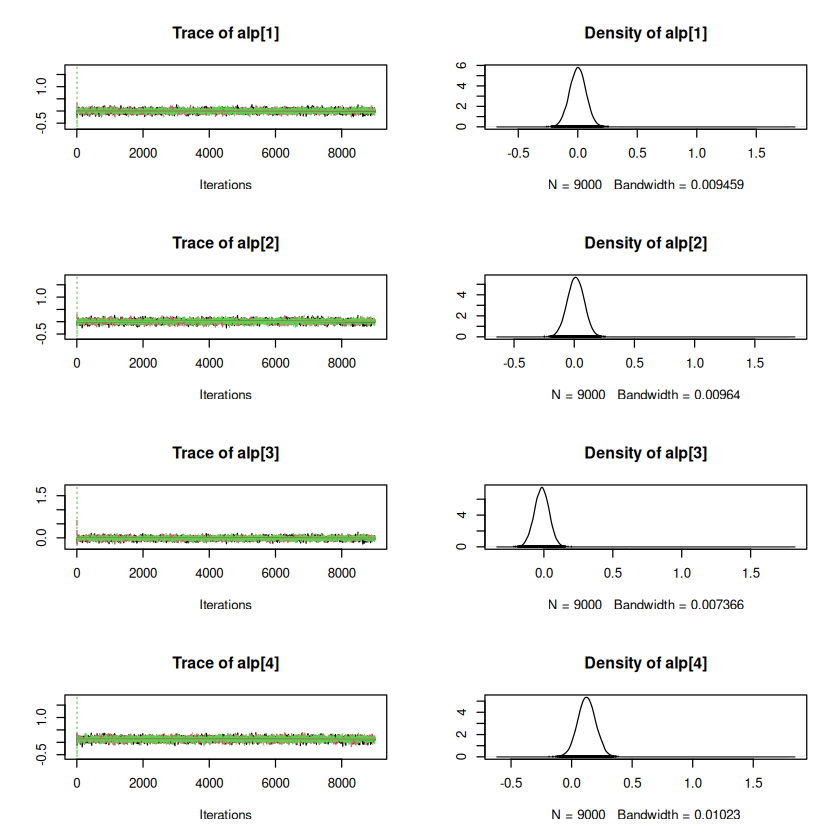

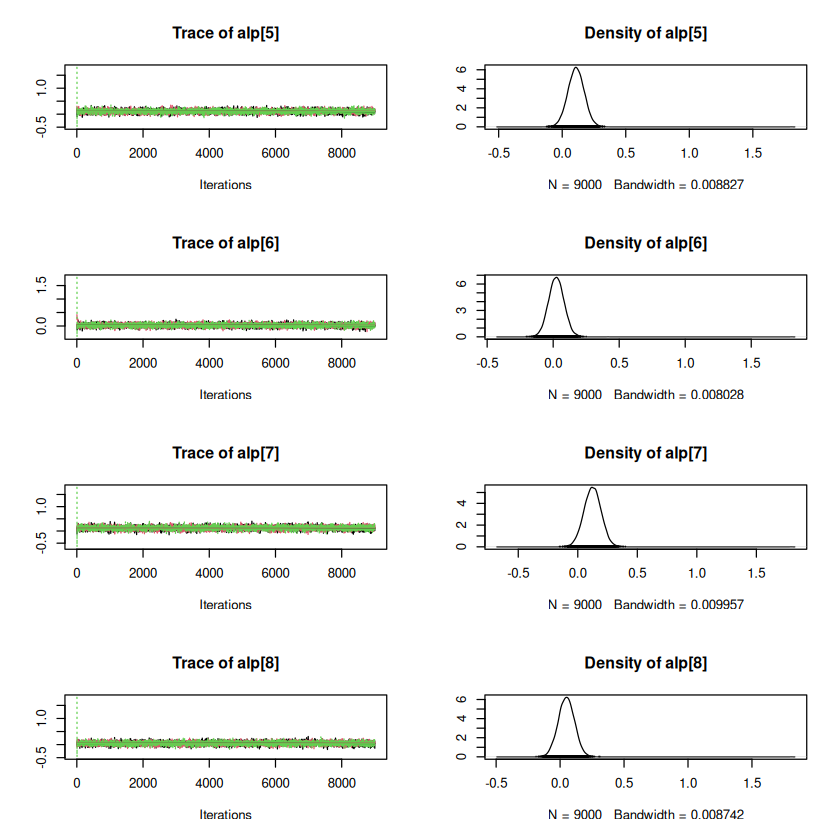

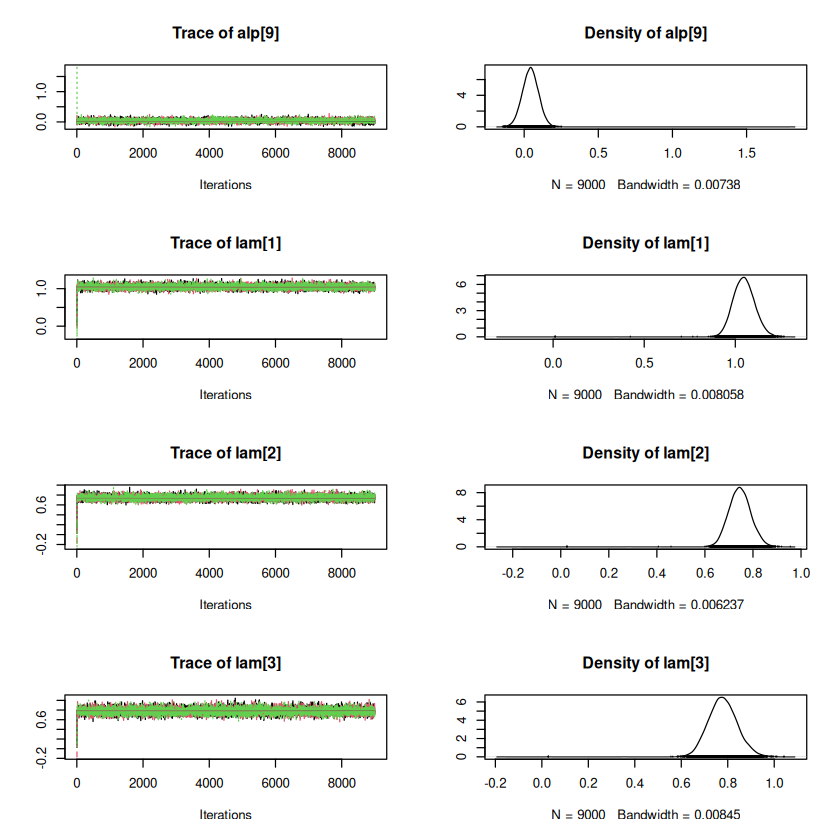

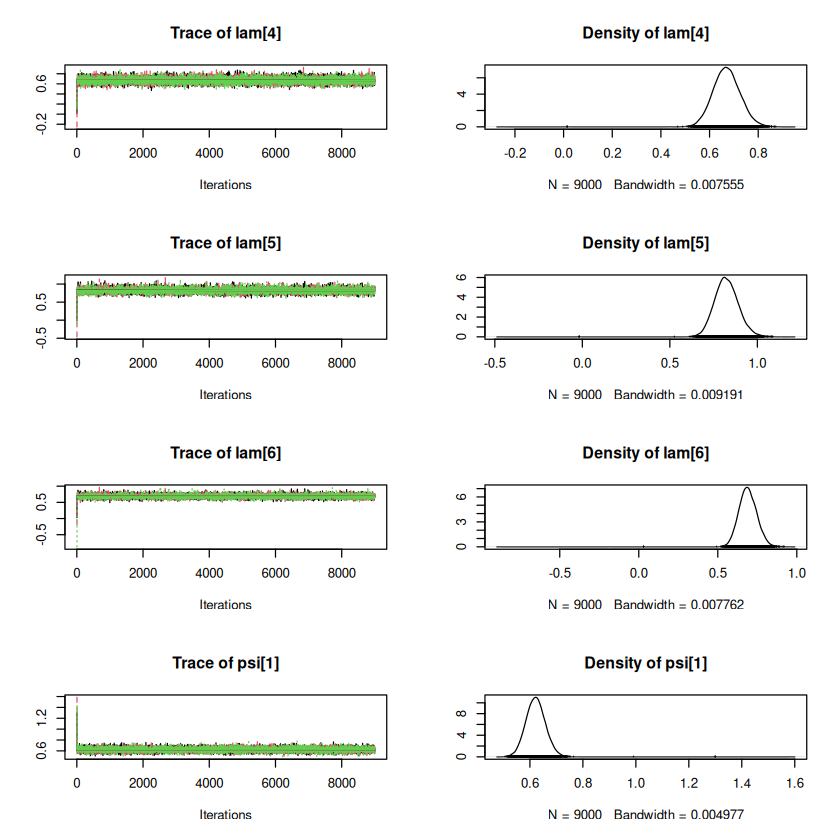

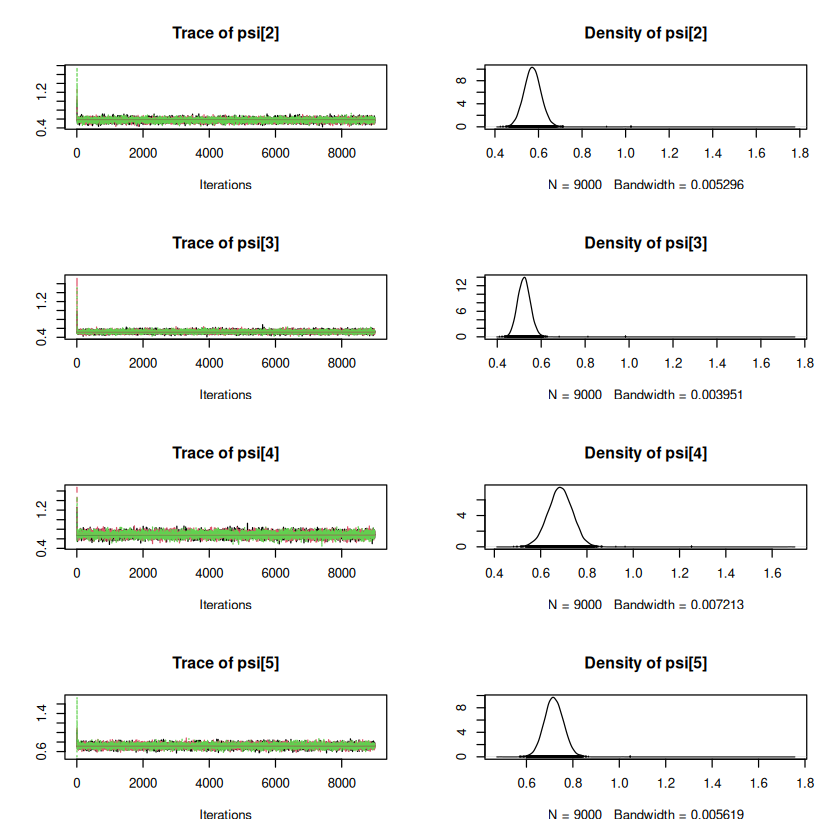

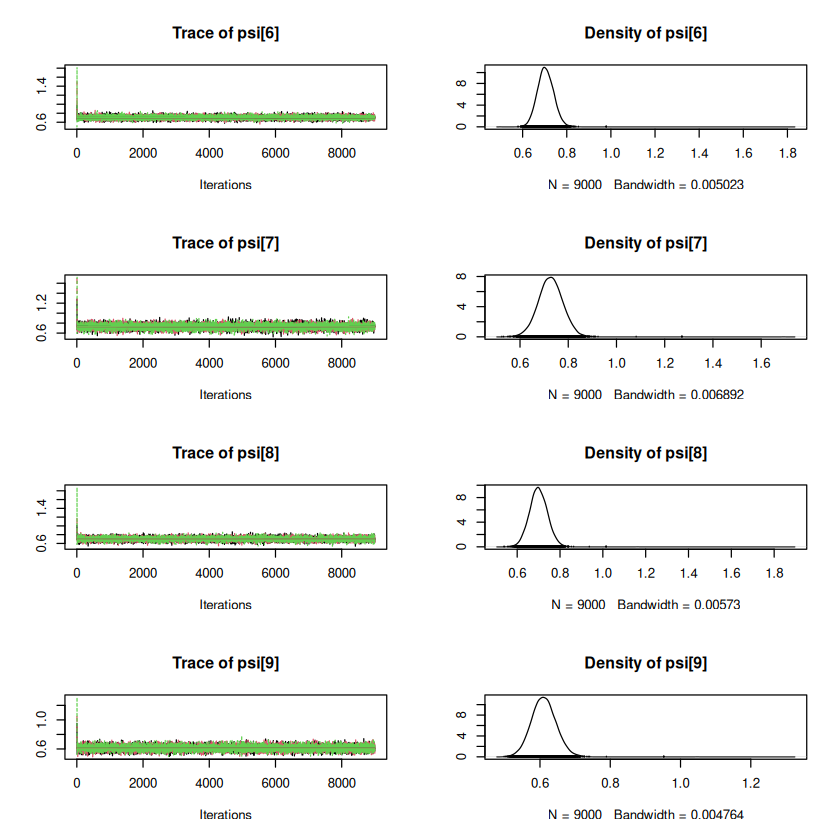

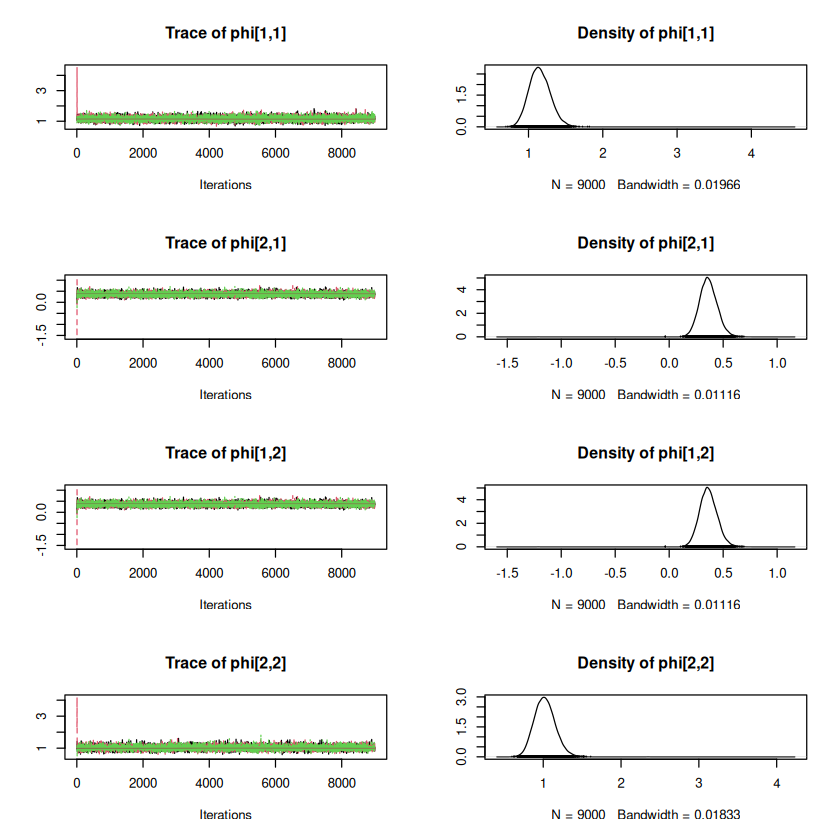

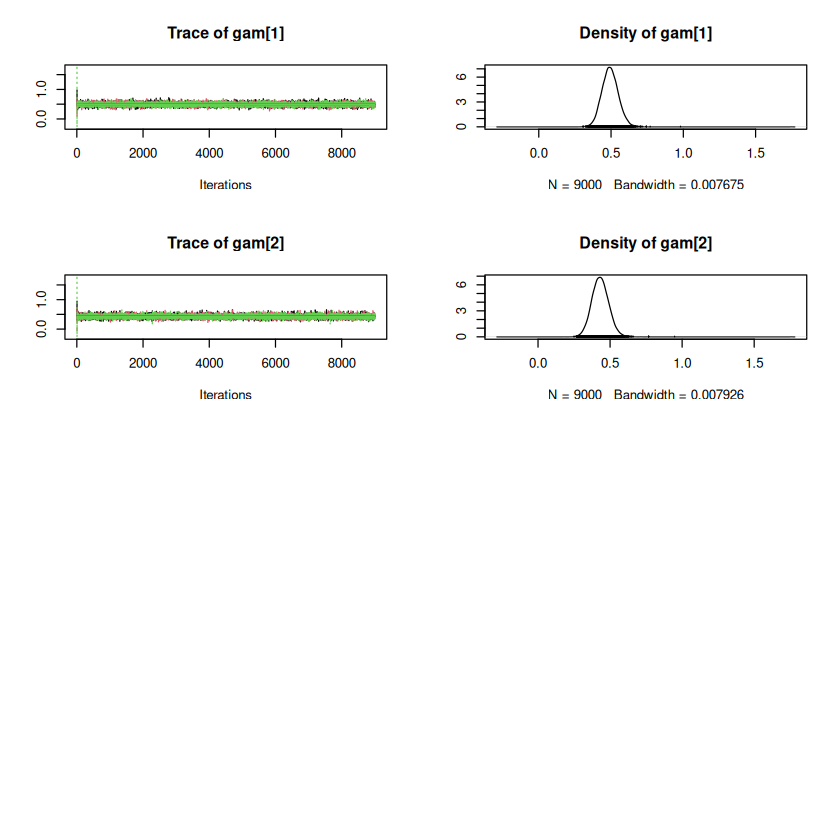

In [ ]:
# Extract posterior draws for variables of interest.
fit$draws(
    variables = c("alp", "lam", "psi", "phi", "gam"),
    inc_warmup = TRUE,
    format = "df"
) %>% 
# Split data frame into list of dataframes by chain number.
split(f = .$.chain) %>% 
# Drop unneeded variables and convert to MCMC object.
lapply(
    function(x) {
        select(x, -c(".chain", ".iteration", ".draw")) %>%
        mcmc()
    }
)  %>%
# Plot posterior draws
mcmc.list() %>%
plot()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


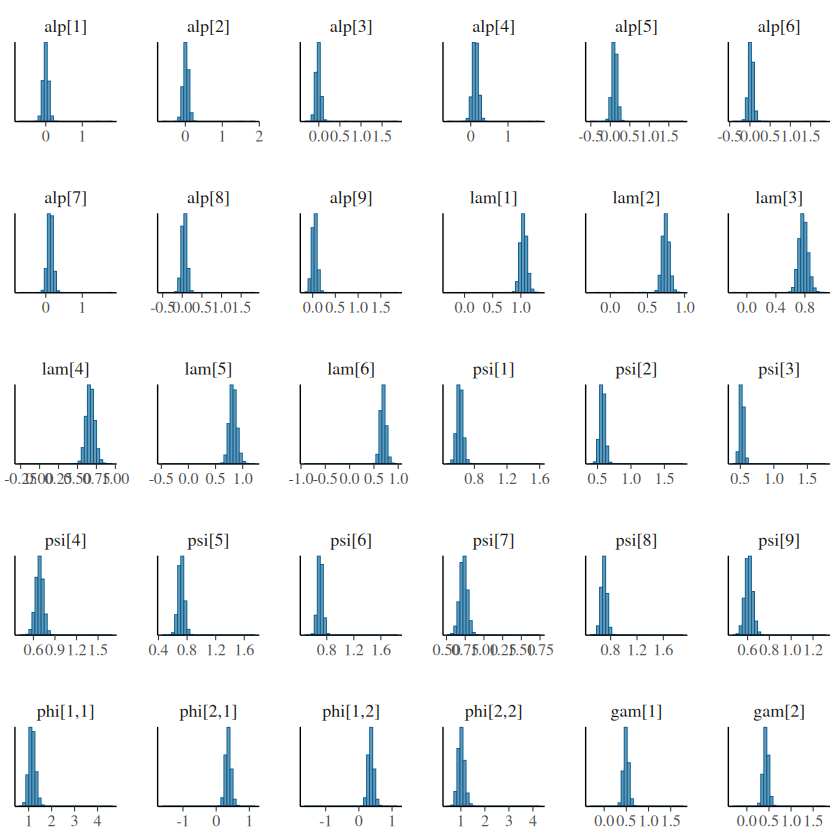

In [185]:
# Extract posterior draws for variables of interest.
fit$draws(
    variables = c("alp", "lam", "psi", "phi", "gam"),
    inc_warmup = TRUE,
    format = "df"
) %>% 
bayesplot::mcmc_hist()

In [208]:
fit$sampler_diagnostics(format = "df")

treedepth__,divergent__,energy__,accept_stat__,stepsize__,n_leapfrog__,.chain,.iteration,.draw
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
4,0,880.05,0.64717,0.23515,15,1,1,1
4,0,908.48,0.73822,0.23515,15,1,2,2
4,0,973.01,0.63850,0.23515,15,1,3,3
4,0,953.71,1.00000,0.23515,15,1,4,4
4,0,929.52,0.79082,0.23515,15,1,5,5
4,0,902.95,0.77680,0.23515,15,1,6,6
4,0,896.74,0.62654,0.23515,15,1,7,7
4,0,929.78,0.77045,0.23515,15,1,8,8
4,0,968.45,0.80017,0.23515,15,1,9,9


In [209]:
fit$diagnostic_summary()

$num_divergent
[1] 0 0 0

$num_max_treedepth
[1] 0 0 0

$ebfmi
[1] 0.6767530 0.6535558 0.6500282

##### Step 4: Obtain Bayesian statistics

To get estimates for omega_i, i.e. node `xi` (which was omitted in step 1), re-run `bugs()` with  the `parameters.to.save` updated, additional iterations (for example, 4000 or 5000) and `codaPkg = FALSE`. Note that the output results are displayed by a column vector (`xi[1,1],xi[1,2],xi[1,3],xi[2,1],xi[2,2],xi[2,3],......,xi[100,1],xi[100,2],xi[100,3]`)

The results for statistics inference, for example, the mean (the Bayesian estimates), standard deviation, Monte Carlo error, will be given in the output of `bugs()` and in the log file. To get the corresponding DIC values, set bugs()' argument `DIC = TRUE` (default).


In [214]:
fit_mle <- model$optimize(
  data = data,
  seed = 69,
  refresh = 500,
  # init = inits,
  sig_figs = 5,
  opencl_ids = NULL,
  iter = n.burnin + n.iter
)


Initial log joint probability = -26969.3 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes  
     499       2860.84    0.00961178   3.05931e+07      0.5094           1      574    
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes  
     999       3434.15     0.0107048   2.60534e+11           1           1     1177    
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes  
    1142       3434.24     8.768e-05   7.70675e+09      0.2003      0.8306     1340    
Optimization terminated normally:  
  Convergence detected: relative gradient magnitude is below tolerance 
Finished in  0.4 seconds.


In [220]:
fit_mle$summary() # includes lp__ (log prob calculated by Stan program)
fit_mle$mle(c("alp", "lam", "psi", "phi", "gam","xi"))

variable,estimate
<chr>,<dbl>
lp__,3434.200000
alp[1],0.350090
alp[2],-0.552900
alp[3],-1.001300
alp[4],0.155210
alp[5],0.020310
alp[6],-0.182340
alp[7],0.267330
alp[8],0.189200


alp[1]      alp[2]      alp[3]      alp[4]      alp[5]      alp[6]      alp[7]      alp[8]      alp[9]      lam[1] 
 0.35009000 -0.55290000 -1.00130000  0.15521000  0.02031000 -0.18234000  0.26733000  0.18920000  0.19202000  5.68470000 
     lam[2]      lam[3]      lam[4]      lam[5]      lam[6]      psi[1]      psi[2]      psi[3]      psi[4]      psi[5] 
 4.83680000  1.42080000  1.65130000  3.23210000  1.72390000  2.89600000 72.79500000 19.27300000  1.06670000  0.55789000 
     psi[6]      psi[7]      psi[8]      psi[9]    phi[1,1]    phi[2,1]    phi[1,2]    phi[2,2]      gam[1]      gam[2] 
 4.08440000  1.38970000  3.06570000  0.64424000  0.89741000 -0.22704000 -0.22704000 15.76500000  0.50000000  0.50000000 
    xi[1,1]     xi[2,1]     xi[3,1]     xi[4,1]     xi[5,1]     xi[6,1]     xi[7,1]     xi[8,1]     xi[9,1]    xi[10,1] 
 0.68325000  0.72381000  0.53783000 -0.35082000 -1.00180000  0.00984550  0.33975000  0.50471000 -0.20739000 -0.29417000 
   xi[11,1]    xi[12,1]    xi[13,1]    xi[14,1]    xi[15,1]    xi[16,1]    xi[17,1]    xi[18,1]    xi[19,1]    xi[20,1] 
-0.47765000 -0.77178000 -0.23955000  0.17028000  0.79604000  1.36560000  1.78200000  1.23840000 -0.48131000 -0.34357000 
   xi[21,1]    xi[22,1]    xi[23,1]    xi[24,1]    xi[25,1]    xi[26,1]    xi[27,1]    xi[28,1]    xi[29,1]    xi[30,1] 
-0.07771500  0.29097000  1.22180000  0.23686000  1.38930000  1.02360000 -0.45018000  0.78604000  0.39152000 -0.14359000 
   xi[31,1]    xi[32,1]    xi[33,1]    xi[34,1]    xi[35,1]    xi[36,1]    xi[37,1]    xi[38,1]    xi[39,1]    xi[40,1] 
 0.57874000  0.45026000  0.48095000 -0.31629000 -0.16331000  0.11143000  0.54322000  0.08887200  0.20262000 -0.33571000 
   xi[41,1]    xi[42,1]    xi[43,1]    xi[44,1]    xi[45,1]    xi[46,1]    xi[47,1]    xi[48,1]    xi[49,1]    xi[50,1] 
 0.53269000  0.32561000  0.00806360  0.37146000  0.06381600  0.27461000 -0.06342700  0.78829000  0.28032000 -0.80845000 
   xi[51,1]    xi[52,1]    xi[53,1]    xi[54,1]    xi[55,1]    xi[56,1]    xi[57,1]    xi[58,1]    xi[59,1]    xi[60,1] 
-0.24400000  0.32400000 -0.85719000 -0.94723000 -0.82962000 -0.24200000  0.39623000  0.56806000 -0.32284000 -0.65070000 
   xi[61,1]    xi[62,1]    xi[63,1]    xi[64,1]    xi[65,1]    xi[66,1]    xi[67,1]    xi[68,1]    xi[69,1]    xi[70,1] 
-0.54001000  1.46050000  0.00966750  0.48869000  0.12240000  0.96782000 -0.44819000 -0.79026000  0.94293000 -0.56186000 
   xi[71,1]    xi[72,1]    xi[73,1]    xi[74,1]    xi[75,1]    xi[76,1]    xi[77,1]    xi[78,1]    xi[79,1]    xi[80,1] 
-0.48857000 -0.88635000 -0.36001000 -0.09068400 -0.04273600 -0.48285000 -1.52070000  1.11330000 -0.15012000  0.53718000 
   xi[81,1]    xi[82,1]    xi[83,1]    xi[84,1]    xi[85,1]    xi[86,1]    xi[87,1]    xi[88,1]    xi[89,1]    xi[90,1] 
-0.98474000  0.48911000 -1.09180000  0.60700000 -0.03710600  0.31382000 -0.57341000 -0.00075001  0.04873600  0.07030400 
   xi[91,1]    xi[92,1]    xi[93,1]    xi[94,1]    xi[95,1]    xi[96,1]    xi[97,1]    xi[98,1]    xi[99,1]   xi[100,1] 
 0.12118000  0.82709000  0.93663000 -1.26780000  0.24732000  0.39609000  0.83624000 -0.00132710 -0.16244000 -0.71263000 
  xi[101,1]   xi[102,1]   xi[103,1]   xi[104,1]   xi[105,1]   xi[106,1]   xi[107,1]   xi[108,1]   xi[109,1]   xi[110,1] 
-1.09550000  0.22527000  0.65026000  0.35894000  0.17472000  0.54587000 -0.37122000 -0.57353000 -0.55573000  0.77131000 
  xi[111,1]   xi[112,1]   xi[113,1]   xi[114,1]   xi[115,1]   xi[116,1]   xi[117,1]   xi[118,1]   xi[119,1]   xi[120,1] 
 0.44441000 -0.19996000 -0.89361000  0.13013000 -0.28874000 -0.14404000 -0.04257000 -1.39510000  0.21825000 -0.57035000 
  xi[121,1]   xi[122,1]   xi[123,1]   xi[124,1]   xi[125,1]   xi[126,1]   xi[127,1]   xi[128,1]   xi[129,1]   xi[130,1] 
-0.78570000 -0.77000000 -0.83308000  0.28715000 -0.15350000 -0.17333000  0.97919000 -0.41160000 -0.60230000  0.33852000 
  xi[131,1]   xi[132,1]   xi[133,1]   xi[134,1]   xi[135,1]   xi[136,1]   xi[137,1]   xi[138,1]   xi[139,1]   xi[140,1] 
-0.30559000 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


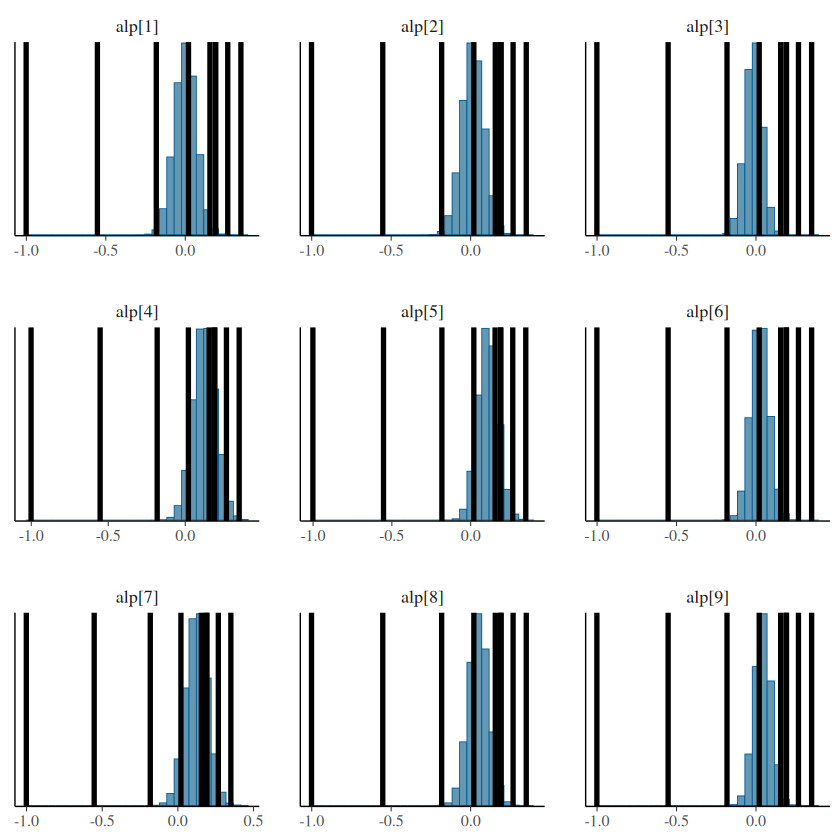

In [219]:
bayesplot::mcmc_hist(fit$draws(c("alp"))) +
  bayesplot::vline_at(fit_mle$mle(c("alp")), size = 1.5)

In [131]:
fit$summary()

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-4.918910e+02,-4.91525e+02,31.26118644,31.12718700,-5.441105e+02,-440.9385000,1.0006246,1696.8372,3645.016
alp[1],-9.288225e-04,-6.62295e-04,0.06780684,0.06846529,-1.110760e-01,0.1096620,1.0031191,768.8887,1968.179
alp[2],1.208651e-02,1.19370e-02,0.06898317,0.06987271,-1.012615e-01,0.1257615,1.0040222,709.0050,2244.643
alp[3],-1.586837e-02,-1.55680e-02,0.05298921,0.05373980,-1.030900e-01,0.0718985,1.0032564,850.0432,2333.945
alp[4],1.243798e-01,1.23895e-01,0.07382511,0.07407144,2.294710e-03,0.2471235,1.0012784,1016.0284,3031.444
alp[5],1.088403e-01,1.08795e-01,0.06344273,0.06327070,4.248760e-03,0.2133640,1.0010969,1203.8153,2930.018
alp[6],2.370428e-02,2.25820e-02,0.05802954,0.05790887,-7.079905e-02,0.1201430,1.0008236,1372.2326,3838.361
alp[7],1.212670e-01,1.21805e-01,0.07147418,0.07207660,2.934205e-03,0.2384020,1.0036967,1041.3761,3206.486
alp[8],4.786579e-02,4.78255e-02,0.06234338,0.06206460,-5.609300e-02,0.1500050,1.0039955,1137.3732,3636.246


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


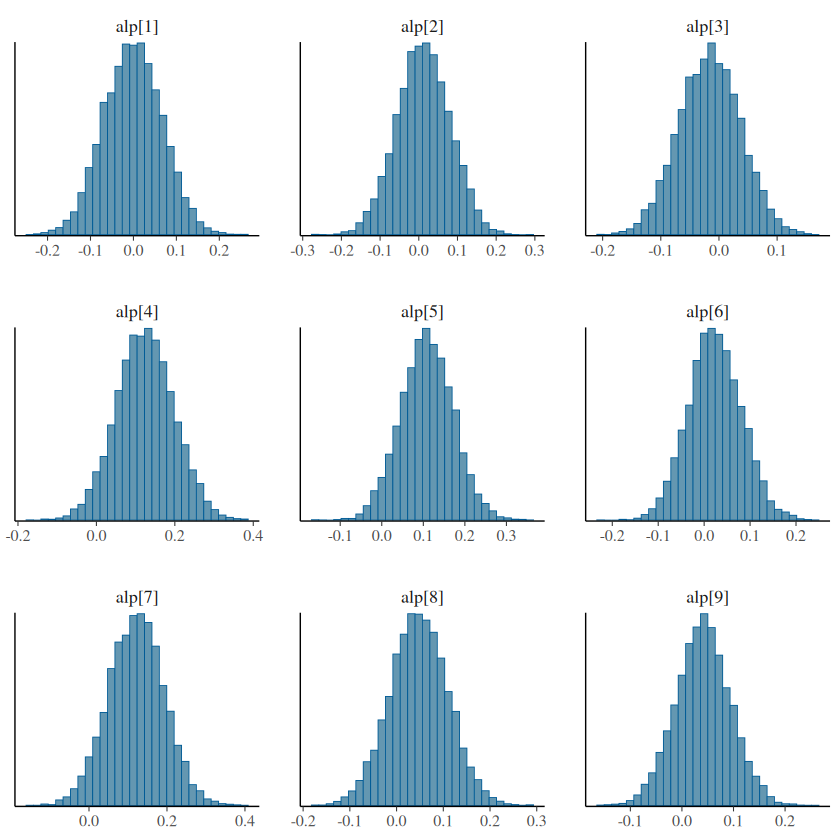

In [137]:
bayesplot::mcmc_hist(fit$draws("alp"))

In [39]:
model.out <- bugs(
    data, 
    inits, 
    param, 
    model.file = model, 
    2*n.iter, 
    n.burnin = n.burnin, 
    codaPkg = FALSE,  # Get bugs object
    working.directory = paste0(getwd(), "/Chapter4/bugs-output")
)
model.out
save.image()

Inference for Bugs model at "/home/pal_bjartan/Backup/PhD/SEM-test-model/Lee2007/Chapter4/ch4-R2OpenBUGS-model.txt", 
Current: 3 chains, each with 10000 iterations (first 2000 discarded)
Cumulative: n.sims = 24000 iterations saved
            mean   sd   2.5%    25%    50%    75%  97.5% Rhat n.eff
alp[1]       0.0  0.1   -0.1    0.0    0.0    0.1    0.1    1  3000
alp[2]       0.0  0.1   -0.1    0.0    0.0    0.1    0.2    1  4200
alp[3]       0.0  0.1   -0.1    0.0    0.0    0.0    0.1    1  3000
alp[4]       0.1  0.1    0.0    0.1    0.1    0.2    0.3    1  2100
alp[5]       0.1  0.1    0.0    0.1    0.1    0.2    0.2    1  9200
alp[6]       0.0  0.1   -0.1    0.0    0.0    0.1    0.1    1 24000
alp[7]       0.1  0.1    0.0    0.1    0.1    0.2    0.3    1  2000
alp[8]       0.1  0.1   -0.1    0.0    0.1    0.1    0.2    1  1800
alp[9]       0.0  0.1   -0.1    0.0    0.0    0.1    0.2    1  2000
lam[1]       1.0  0.1    0.9    1.0    1.0    1.1    1.2    1 24000
lam[2]       0.7  0.0